#Offline Reinforcement Learning

This program will take in *hand labelled* Epileptor data. The data will be in the form of a tuple:
    
    data = (  t,
    state[t]:  state vector at t,
    action[t]: action taken at t + 1 (decided on based on state[t], or action log) ,
    reward[t]: reward from this action-state pair (based on state[t+1] and action[t])
    * add next state?

Where, for simplicity, 

    state vector = ( average of 10 ms ) 
    
    reward = (-100) for seizure
             (-10) - (-50) for stimulation
             


In [1]:
%pylab nbagg
from tvb.simulator.lab import *


Populating the interactive namespace from numpy and matplotlib
   INFO  log level set to INFO


In [2]:
from sklearn.ensemble import ExtraTreesRegressor
import operator

I have created a library with a few very useful functions for The Virtual Brain. This can be found in sim.py.

In [3]:
import sim

#Extracting Features and State Vectors

In [4]:
def extract_features(raw_time, raw_data):
    data_min = np.min(raw_data[:],0)[0]
    data_max = np.max(raw_data[:],0)[0]
    data_rng = data_max - data_min
    data_avg = np.mean(raw_data[:], 0)[0]
    return (data_min, data_max, data_rng, data_avg)

In [5]:
def state_vector(region, features, oldstate, olderstate):
    
    
    s_vector = [0,0,0,0]
#    if features[2][region][0] < 0:
#        s_vector[0] = 0
#    else:
#        s_vector[0] = 1

    s_vector[0] = features[2][region][0]

#    power = features[4] * features[3]**2 #time * amp^2
    
    
    #for actions above, power is 0, 5 or 250
    
#    if power == 0:
#        s_vector[1] = 0
#    elif power < 10:
#        s_vector[1] = 1
#    else:
#        s_vector[1] = 2
 
    s_vector[1] = oldstate[0]
    s_vector[2] = olderstate[0]
    s_vector[3] = features[3] #action taken
    
#    return (s_vector[0],oldstate[0],olderstate[1], s_vector[1])
    return (s_vector[0],oldstate[0],olderstate[0], features[3])

#    return  (s_vector[0],0,0, s_vector[1])


In [6]:
def state_vector_complicated(region, features):
    
    s_vector = [0,0,0,0]
    
    #minimum
    if features[0][region][0] < -1:
        s_vector[0] = 0
    else:
        s_vector[0] = 1
        
    #maximum 
    if features[1][region][0] < 1:
        s_vector[1] = 0
    else:
        s_vector[1] = 1
    
    #average
    if features[2][region][0] < 0:
        s_vector[2] = 0
    else: 
        s_vector[2] = 1
    
    power = features[4] * features[3]**2
    
    #power
#    if power == 0:
#        s_vector[3] = 0
#    elif power <= 5:
#        s_vector[3] = 1
#    else:
#        s_vector[3] = 2
    s_vector[3] = power
    
    return (s_vector[0], s_vector[1], s_vector[2], s_vector[3])
    

#Defining the action space
These functions translate actions to stimulation parameters, and set the penalty based on each action depending on the power delivered to the brain.

In [7]:
def set_stim_parameters(action, stim):
    if action == 0:
        stim.temporal.parameters["amp"] = 0
        stim.temporal.parameters["T"] = 10
        stim.temporal.parameters["tau"] = 0
        # Power = 0
        
    elif action == 1:
        stim.temporal.parameters["amp"] = 1
        stim.temporal.parameters["T"] = 5
        stim.temporal.parameters["tau"] = 2.5
        # Power = 5
        
    elif action == 2:
        stim.temporal.parameters["amp"] = 1
        stim.temporal.parameters["T"] = 10
        stim.temporal.parameters["tau"] = 5
        # Power = 5
        
    elif action == 3:
        stim.temporal.parameters["amp"] = 5
        stim.temporal.parameters["T"] = 5
        stim.temporal.parameters["tau"] = 2.5 
        # Power = 20
        
    elif action == 4:
        stim.temporal.parameters["amp"] = 5
        stim.temporal.parameters["T"] = 10
        stim.temporal.parameters["tau"] = 5
        # Power = 20   
        
    elif action == 5:
        stim.temporal.parameters["amp"] = 5
        stim.temporal.parameters["T"] = 5
        stim.temporal.parameters["tau"] = 2.5
        # Power = 125
            
    elif action == 6:
        stim.temporal.parameters["amp"] = 20
        stim.temporal.parameters["T"] = 10
        stim.temporal.parameters["tau"] = 10
        # Power = 125

In [8]:
def stim_penalty(action_taken):
    #stimulus penalty = - power delivered * power_coeff
    
    power_coeff = 0.4
    
    if action_taken == 0:
        return 0
    elif action_taken == 1 or action_taken == 2:
        return -5 * power_coeff
    elif action_taken == 3 or action_taken == 4:
        return -20 * power_coeff
    else:
        return -125 * power_coeff


In [48]:
def get_freq_amp(action_log):
    freq = []
    amp = []
    for action in action_log:
        if action == 0:
            freq.append(0)
            amp.append(0)
        if action == 1:
            freq.append(500)
            amp.append(1)
        if action == 2:
            freq.append(250)
            amp.append(1)
        if action == 3:
            freq.append(500)
            amp.append(2)
        if action == 4:
            freq.append(250)
            amp.append(2)
        if action == 5:
            freq.append(500)
            amp.append(5)
        if action == 6:
            freq.append(250)
            amp.append(5)
        
    return (amp, freq)

#Make some data
Here is some code to create some dummy training data. More data with 
various modes of stimulation will be created later. Start by creating a simulation

In [1]:
epileptic = [9]
almost_epileptic = []
stimulus_target = [9]
stimulus_amplitude = -20
stimulus_weight = 2 #0-2 for each region
onset = 0
period = 500
pulse_width = 0
sim_time = 50000
dt = 100

valid_action = [0,3,4]

(s, stimulus) = sim.set_sim(epileptic, almost_epileptic, stimulus_target, stimulus_amplitude, 
              stimulus_weight, onset, period, pulse_width, sim_time)

NameError: name 'sim' is not defined

Get rid of noisy initial conditions

In [50]:
s.run(simulation_length=3000)
print("")

In [51]:
dataset = []


Create some action plan to create data

In [52]:
action_plan = []
for i in range (sim_time/dt):
    action_plan.append(0)
    if random.random() < 0.6:
        action_plan[i] = random.choice(valid_action)
            

Put data into tuples described above, sans reward.

In [53]:
states = []
action = 0
for i in range(sim_time/dt):
    
    #Print to have an idea of how far the execution is
    if i%10 == 0:
        print "\ntime is: " + str(i*dt)
    


    #simulate for dt
    (t, a), (x1, x2), (y1, y2) = s.run(simulation_length = dt)
    
    #append the result of the short simulation to the full list
    if i == 0:
        tt = copy(t - 2999.5)
        aa = copy(a)
    else:
        tt = np.append(tt, t - 2999.5, axis=0)
        aa = np.append(aa, a, axis=0) 
     
    
    
    #create features vector
    (imins, imaxs, irng, iavg) = extract_features(t,a)
    features = (imins, imaxs, iavg, action) 
    
    #create values to be passed to the dataset
    time = t[0] - 2999.5
    if i > 1:
        s_vector = state_vector(9, features, states[i-1], states[i-2])
    else:
        s_vector = state_vector(9, features, (1,1,1,0), (1,1,1,0))
        
    #since this is offline learning, we will follow a different action plan
    action = action_plan[i]
    set_stim_parameters(action, stimulus)
        
    states.append(s_vector)
    
    if i > 0:
        dataset[i-1] = dataset[i-1] + (s_vector,)
    
    dataset.append((time, s_vector, action))


time is: 0

time is: 1000

time is: 2000

time is: 3000

time is: 4000

time is: 5000

time is: 6000

time is: 7000

time is: 8000

time is: 9000

time is: 10000

time is: 11000

time is: 12000

time is: 13000

time is: 14000

time is: 15000

time is: 16000

time is: 17000

time is: 18000

time is: 19000

time is: 20000

time is: 21000

time is: 22000

time is: 23000

time is: 24000

time is: 25000

time is: 26000

time is: 27000

time is: 28000

time is: 29000

time is: 30000

time is: 31000

time is: 32000

time is: 33000

time is: 34000

time is: 35000

time is: 36000

time is: 37000

time is: 38000

time is: 39000

time is: 40000

time is: 41000

time is: 42000

time is: 43000

time is: 44000

time is: 45000

time is: 46000

time is: 47000

time is: 48000

time is: 49000


In [54]:
#figure = figsize(10, 8)

#plot((tt[:]),aa[:,0,9,0], 'k')

#plot(10*(tt[1:(len(avg[9])+1)]-3000), np.array(action_log)/6. - 3, 'k')
#(amp_plot, freq_plot) = get_freq_amp(action_plan)


#plot( 100*(tt[:(len(action_plan))]), np.array(states)[:,0]/2. - 5, 'b')
#plot( dt+100*(tt[:(len(action_plan))]), np.array(amp_plot)/6. - 4, 'b')


#plot(10*(tt[1:(len(avg[9])+1)]-3000), np.array(freq_plot)/200. - 3, 'g')
#title("2-state 2-action Q-learning Algorithm \n Simplified state (memoryless)")

#show()

Now, we need to add rewards to the set based on our hand-labelling of the results.

    reward = -100 (seizure at state t+1?) + (penalty for action at t)

IRL, we would put the seizure start and end times here. But, epileptor doesn't require hand labelling, so we can just plug in our seizure detection indicator (avg of the lfp) in the loop.

In [55]:

t_seizures = ( (-50,150), (2650,2850), (4750,5150),(7250,7350),(9150,10000000) ) #tuples representing seizure onset-offset.
                                                  #put 0 if seizure starts before frame, 
                                                  #very big number if ends after frame
                                                  #offset by -dt/2 for some reason
            
            #Bug: every 20th stimulation, dt = 99 instead of 100. What the hell TVB?
            #Offset by -dt/2 for now. This makes sures that frame onsets are caught within these bounds.

In [77]:
f_data = []
for i in range(0, len(dataset) -1 ):
    point = dataset[i]
    nextpoint = dataset[i+1]
    nexttime = nextpoint[0]
    action_taken = point[2]
    reward = 0
    
    #determine whether this point is a seizure
    ictal = 0
#    for seizure in t_seizures:
#        if seizure[0] <= time and time < seizure[1]:
#            ictal = 1
    if point[1][0] < 0:
        ictal = 1
    #we can cheat since this means seizure


    if ictal:
        reward -= 500
    else:
        reward = 0
    
    reward += stim_penalty(action_taken)
    
    f_data.append(point[:3] + (reward,) + (nextpoint[1],))
    
        

#Fitted Q Iteration
We will use Guez's algorithm from his Master's thesis, making use of a regression algorithm to iteratively find an ideal Q function (not a table!).

Algorithm will go like this:

    input: dataset = {(s_t, a_t, r_t) for all t}
           regression algorithm, r
          
    N = 0
    Q(s,a) = 0 for all s,a
    
    while (some condition):
        N += 1
        TS = (i,o) where i = (s_t, a_t); o = (r_t + gamma * maxq_s2)
        Q = r(TS)



In [78]:

alpha = 0.2
epsilon = 0
#q_table = {}

Create the ExtraTrees Regressor

In [79]:
xtrain = []
nextstates = []
ytrain = []
for point in f_data:
    xtrain.append([ point[1][0],point[1][1],point[1][2],point[1][3],point[2] ])
    ytrain.append(point[3])
    nextstates.append([point[4][0],point[4][1],point[4][2],point[4][3]])
xtrain = np.array(xtrain)
nextstates = np.array(nextstates)
ytrain = np.array(ytrain)

In [3]:
x = nan

NameError: name 'nan' is not defined

In [80]:
def iterate_q(ins, outs, nextstates, iterations,gamma = 0.6):
    etrees = ExtraTreesRegressor(max_features = 5)
    N = 0;
    for x in range(iterations):
        N += 1
        out_new = copy(outs)
        if N > 1:
            for i in range(len(outs)):
                
                bestaction = random.choice(valid_action)
                bestval = etrees.predict([[nextstates[i][0], nextstates[i][1], nextstates[i][2], nextstates[i][3], bestaction]])
                for action in valid_action:
                    val = etrees.predict([[nextstates[i][0], nextstates[i][1], nextstates[i][2], nextstates[i][3], bestaction]])
                    if val > bestval:
                        bestaction = action
                        bestval = val
                #print ("nextstate: " + str(nextstates[i]) + " best action: " + str(bestaction) + " val: "+str(bestval) )
                out_new[i] += gamma*bestval #gamma = 0.9
        etrees.fit(ins, out_new)
        if x%(iterations/10.) == 0:
            print "iteration " + str(x)
        
        
    return etrees

In [81]:
def learn_dataset(q_table, dataset):
    for i in range(len(dataset) - 1):
        learn_from_frame(q_table, dataset[i], dataset[i+1])
        
        
def get_q(q_table, state, action):
    return q_table.get((state,action), 0)
    
def update_q(q_table, frame, newval):
    q_table[(frame[1], frame[2])] = newval

def learn_from_frame(q_table, frame1, frame2):
    
    oldval = get_q(q_table, frame1[1], frame1[2])
    
    maxq_frame2 = max([get_q(q_table, frame2[1], a) for a in valid_action]) # = V(s') 
    
    # Q(s,a) <- Q(s,a) + alpha * [reward + gamma * V(s') - Q(s,a)]
    
    newval = oldval + alpha * (frame1[3] + gamma * maxq_frame2 - oldval)
    #should it be different for the first try??
    
    update_q(q_table, frame1, newval)
    

In [82]:
predictor = iterate_q(xtrain, ytrain, nextstates, 50)

iteration 0
iteration 5
iteration 10
iteration 15
iteration 20
iteration 25
iteration 30
iteration 35
iteration 40
iteration 45


In [83]:
q_table = {}
learn_dataset(q_table,f_data)
fqi_table = {}
for key in q_table.keys():
    fqi_table[key] = predictor.predict( [[key[0][0],key[0][1],key[0][2],key[0][3],key[1]]] )[0]   
    
    #print str(key) + ": " + str(fqi_table[key]) + "    " + str(q_table[key])
sorted_fqi = sorted(fqi_table.items(), key=operator.itemgetter(1))
sorted_q = sorted(q_table.items(), key=operator.itemgetter(1))

TypeError: unsupported operand type(s) for *: 'builtin_function_or_method' and 'int'

In [ ]:
for f in f_data:
    print str(f[1]) + str(f[2]) + "     Reward: " + str(f[3])

#Test the Fitted Q Iteration Algorithm!
Hopefully it works.

In [84]:
epileptic = [9]
almost_epileptic = []
stimulus_target = [9]
stimulus_amplitude = -20
stimulus_weight = 2 #0-2 for each region
onset = 0
period = 500
pulse_width = 0
sim_time = 10000
dt = 100

valid_action = [0,3,4]

(s, stimulus) = sim.set_sim(epileptic, almost_epileptic, stimulus_target, stimulus_amplitude, 
              stimulus_weight, onset, period, pulse_width, sim_time)
s.run(simulation_length=3000)
print("")

WARNING  File 'hemispheres' not found in ZIP.



In [85]:
test_states = []
action_log = []
action = 0
for i in range(sim_time/dt):
    
    #Print to have an idea of how far the execution is
    if i%10 == 0:
        print "time: " + str(i*dt)
    


    #simulate for dt
    (t, a), (x1, x2), (y1, y2) = s.run(simulation_length = dt)
    
    #append the result of the short simulation to the full list
    if i == 0:
        ttest = copy(t - 2999.5)
        atest = copy(a)
    else:
        ttest = np.append(ttest, t - 2999.5, axis=0)
        atest = np.append(atest, a, axis=0) 
     
    
    
    #create features vector
    (imins, imaxs, irng, iavg) = extract_features(t,a)
    features = (imins, imaxs, iavg, action) 
    
    #create values to be passed to the dataset
    time = t[0] - 2999.5
    if i > 1:
        s_vector = state_vector(9, features, test_states[i-1], test_states[i-2])
    else:
        s_vector = state_vector(9, features, (1,1,1,0), (1,1,1,0))
        
    #follow action plan!
    bestaction = 0
    bestval = predictor.predict([[s_vector[0], s_vector[1], s_vector[2], s_vector[3],bestaction]])
    for action in valid_action:
        val = predictor.predict([[s_vector[0], s_vector[1], s_vector[2], s_vector[3], action]])
        if val > bestval:
            bestaction = action
            bestval = val
            
    action = bestaction
    action_log.append(bestaction)
    
    set_stim_parameters(action, stimulus)
        
    test_states.append(s_vector)
    
    if i > 0:
        dataset[i-1] = dataset[i-1] + (s_vector,)
    
    dataset.append((time, s_vector, action))

time: 0
time: 1000
time: 2000
time: 3000
time: 4000
time: 5000
time: 6000
time: 7000
time: 8000
time: 9000


<IPython.core.display.Javascript object>


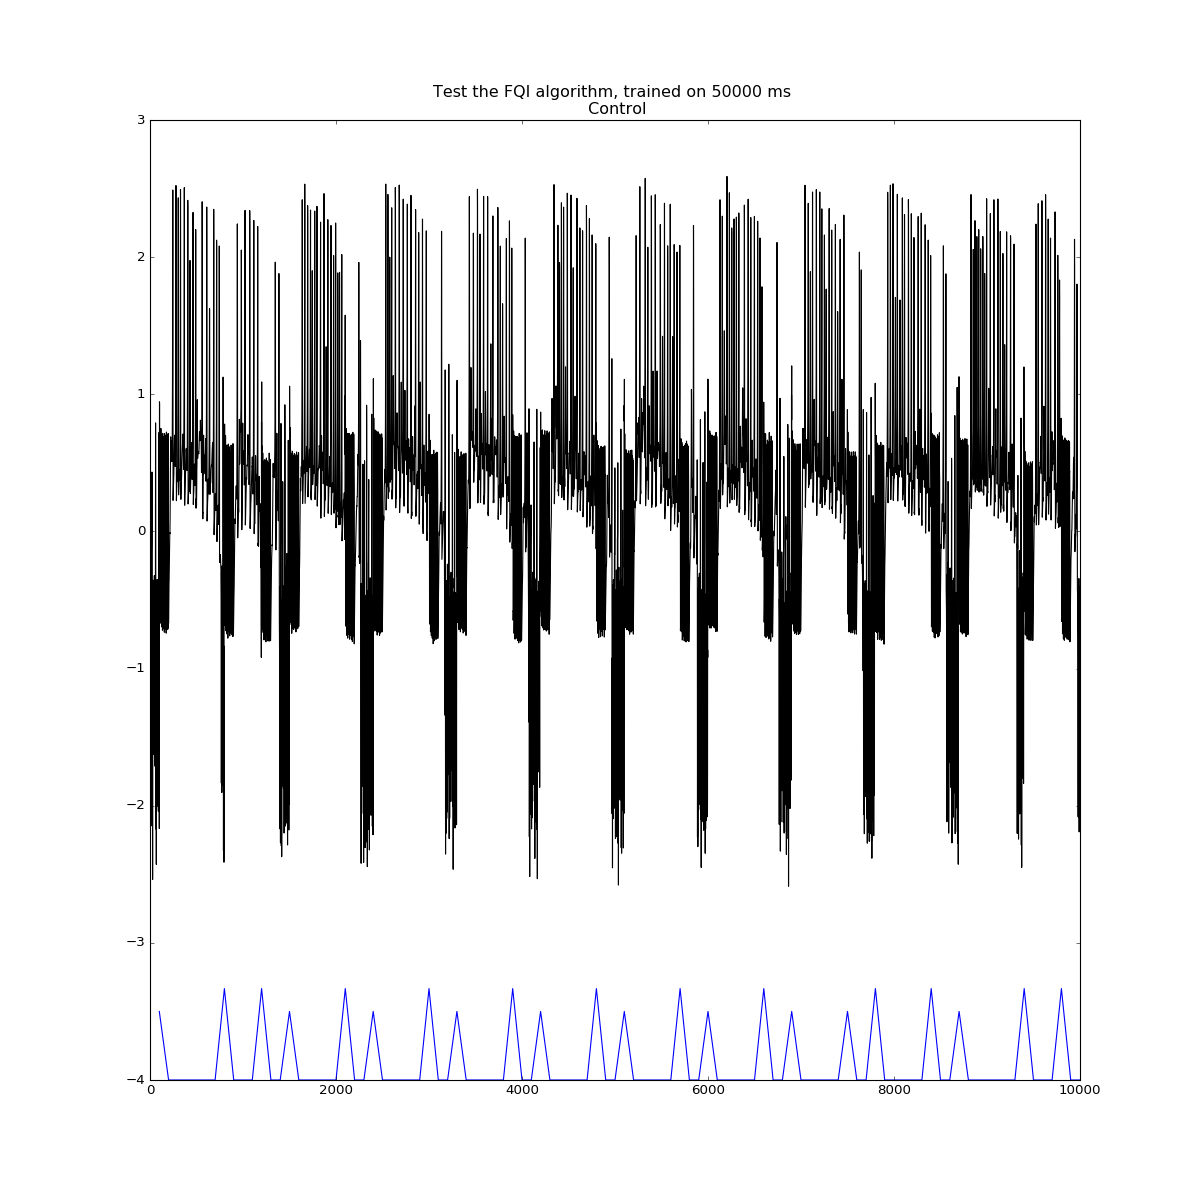

In [86]:
figure(2)
figsize(15,15)
ion()
plot((ttest[:]),atest[:,0,9,0], 'k')

#plot(10*(tt[1:(len(avg[9])+1)]-3000), np.array(action_log)/6. - 3, 'k')
#(amp_plot, freq_plot) = get_freq_amp(action_log)


#plot( 100*(ttest[:(len(action_log))]), np.array(test_states)[:,0]/2. - 5, 'b')
plot( dt+100*(ttest[:(len(action_log))]), np.array(action_log)/6. - 4, 'b')


#plot(10*(tt[1:(len(avg[9])+1)]-3000), np.array(freq_plot)/200. - 3, 'g')
title("Test the FQI algorithm, trained on 50000 ms \n Control")
savefig("Graphs/fqi-actions-100hz_200Hz_amp=5-FIXED VERSION-500ictalpenalty")
show()

In [87]:
ictal_states = 0
interictal_states = 0
for state in test_states:
    if state[0] < 0:
        ictal_states += 1
    else:
        interictal_states += 1
print "Ictal states: " + str(ictal_states) + "\nInter-ictal states: " + str(interictal_states)

Ictal states: 42
Inter-ictal states: 58
